# Algorithm Hierarchical Clustering M

describe

In [104]:

from sklearn.metrics.pairwise import euclidean_distances
import numpy as np 

class Cluster:
    
    def __init__(self, n):
        ''' '''
        self.n = n # номер класетра (начальной точки)
        self.nodes = set([n]) # объединенные с кластером точки 
        self.join_n  = -1 # номер кластера с которым слит
        self.dist = -1 # расстояние при слиянии (dist <= 0)

    def active(self):
        ''' '''
        return self.join_n == -1
        
    def merge(self, c, dist):
        ''' '''
        self.nodes = self.nodes.union(c.nodes) 
        c.join_n = self.n
        c.dist = np.abs(dist)
        
    def get_n(self):
        ''' '''
        if self.join_n == -1:
            return self.n
        return self.join_n
        
class HierarchicalClustering:
    
    def __init__(self, alpha = 1.01, max_iteration = 200, debug= False, delta=0., stop_neg_sum = True, betta = 2.,n_clusters=1):
        ''' '''
        self.alpha = alpha
        self.betta = betta
        self.max_iteration = max_iteration
        self.debug = debug
        self._c_all = []
        self.delta = delta
        self.stop_neg_sum = stop_neg_sum
        self.n_clusters= n_clusters
        self.labels_ = []
            
    
    def fit(self, x):
        ''' '''
        self._c_all = []
        y_ = []
        M =  euclidean_distances(x,x)
        C = []
        size = len(M)
        for i in range(size): 
            C.append( Cluster(i) )
        
        delta = self.delta
        
        for i in range(self.max_iteration): 
            d = np.min(M[M > 0])  
            #d = self._get_min(M, C) * self.alpha
            if d > delta:
                delta = d  
            delta = delta * self.alpha    
            if(self.debug):   
                print('delta: %.3f, d: %.3f' % (delta, d))    
            M_ = M - delta
            ''' join clusters '''
            join = False
        
            for i in range(size):  
                for j in range(i+1,size):  
                    
                    if(M[i][j] <= 0 or M_[i][j] > 0):
                        continue 
                        
                    if C[i].dist > np.abs(M_[i][j]): 
                        continue
                        
                    a = C[i].get_n()
                    b = C[j].get_n() 
                    if(a == b):
                        continue 
            
                    C[a].merge(C[b], M_[i][j]) 
                    for s in C[b].nodes:
                        #C[s].join_n = a
                        C[a].merge(C[s], M_[i][j])
                    join = True        
            if join == False: 
                delta = delta * self.betta 
                continue
            
            M =   M_ 
                    
            if len(M[M > 0]) == 0:
                break
               
            y_ = np.zeros(size)
            cl = 0
            for c in C:
                if(c.active() == True): 
                    for i in c.nodes:
                        y_[i] = cl
                    cl = cl + 1
                    
            self._c_all.append(y_)  
          
            if len(np.unique(y_)) <= self.n_clusters: 
                break
            neg,pos = [],[]    
            for i in range(size): 
                for j in range(i,size):
                    if C[i].active() == False:
                        continue
                    if C[j].active() == False:
                        continue
                        
                    if(M[i][j] <= 0):
                        neg.append(np.abs(M[i][j]) + delta)
                    elif(M[i][j] > 0):
                        pos.append(M[i][j])    
            if(self.debug):
                print('Sum pos: %.3f, sum neg: %.3f, Std pos: %.3f, Std neg: %.3f' % 
                      (sum(pos) , sum(neg) ,np.std(pos), np.std(neg))) 
            if np.std(pos) == 0:
                break
            if self.stop_neg_sum and sum(pos) / len(pos) < sum(neg) / len(neg): 
                print('sum(pos) < sum(neg)')
                break 
        self.labels_ = y_         
        return y_                
        
    def print_name(self):
        print('Hierarchical clustering')
        


In [105]:
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
%matplotlib inline

x = np.array([
    [1,1],
    [1,2],
    [2,2],
    [2,1],
    
    #[4,4],
    
    [5,5], 
    [6,6],
    [6,7],
    
    [3.5,7],
    
    # 
    [3.6,7.1],
    [3.7,6.9],
    [3.8,6.9] 
]) 

def draw(x, y):
    k = 2
    U,s,vh = np.linalg.svd(x) 
    k = min(k, len(s))

    x1 = np.dot(U[:,0:k] * s[0:k], vh[0:k]) 

    plt.rcParams["figure.figsize"] = (12,12)
    plt.scatter(x1[:,0], x1[:,1], c=y)

   

Hierarchical clustering
delta: 0.100, d: 0.100
Sum pos: 174.741, sum neg: 2.000, Std pos: 2.347, Std neg: 0.000
delta: 0.100, d: 0.041
Sum pos: 140.103, sum neg: 2.700, Std pos: 2.326, Std neg: 0.000
delta: 0.100, d: 0.024
Sum pos: 108.195, sum neg: 3.200, Std pos: 2.370, Std neg: 0.000
delta: 0.100, d: 0.016
delta: 0.200, d: 0.016
delta: 0.400, d: 0.016
delta: 0.800, d: 0.016
Sum pos: 19.235, sum neg: 7.600, Std pos: 2.180, Std neg: 0.000
delta: 0.800, d: 0.314
Sum pos: 8.957, sum neg: 8.100, Std pos: 1.722, Std neg: 0.000
delta: 0.800, d: 0.302
Sum pos: 2.957, sum neg: 7.000, Std pos: 0.000, Std neg: 0.000
[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]


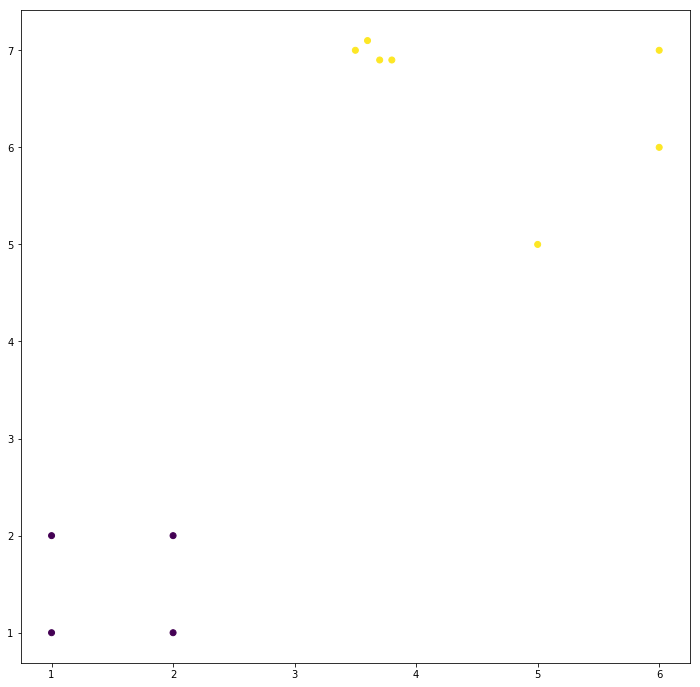

In [106]:
#x = np.array([
#    [1,1],[2.2,2.2],[3.5,3.5],[4.9,4.9]
#])
hc = HierarchicalClustering(alpha = 1.0, debug=True)
hc.print_name()
Y_ = hc.fit(x)
print(Y_)
draw(x, Y_)

[0. 0. 0. 0. 1. 1. 1. 2. 2. 2. 2.]


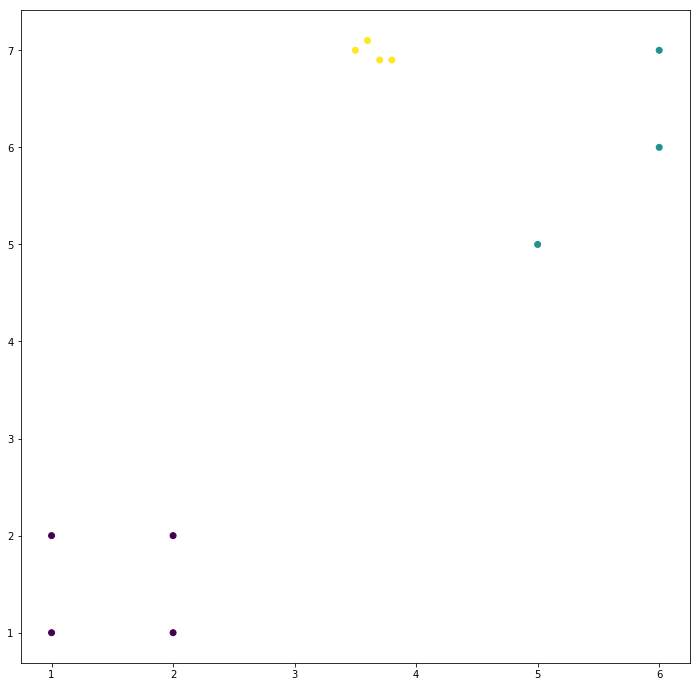

In [107]:
n = -2
print(hc._c_all[n])
draw(x, hc._c_all[n])

delta: 0.130, d: 0.100
Sum pos: 25015.725, sum neg: 37.960, Std pos: 1.620, Std neg: 0.000
delta: 0.169, d: 0.011
Sum pos: 5264.592, sum neg: 32.760, Std pos: 1.584, Std neg: 0.000
delta: 0.220, d: 0.001
Sum pos: 147.568, sum neg: 8.122, Std pos: 1.879, Std neg: 0.000
delta: 0.286, d: 0.001
Sum pos: 12.659, sum neg: 3.270, Std pos: 2.692, Std neg: 0.000
delta: 0.371, d: 0.002
Sum pos: 5.883, sum neg: 3.094, Std pos: 0.000, Std neg: 0.000


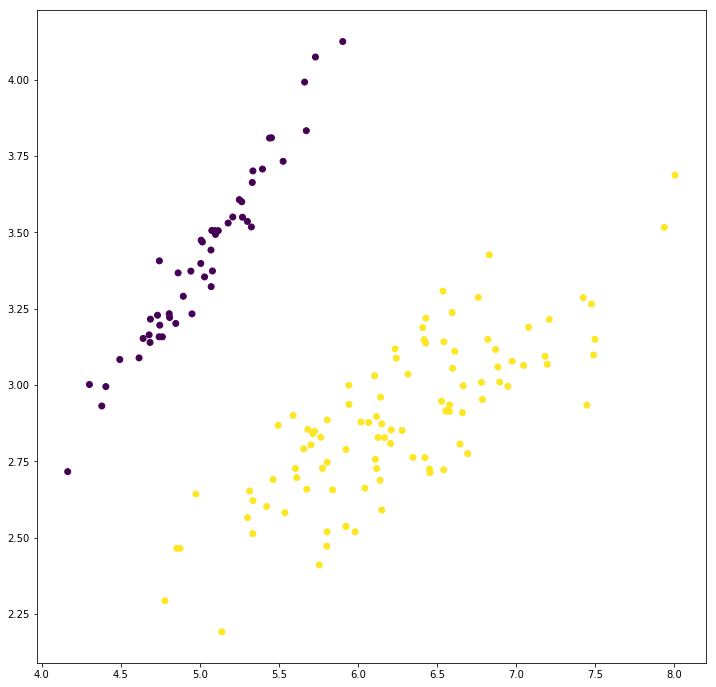

In [108]:
data = load_iris()
ix = data.data
iy = data.target
cl = HierarchicalClustering(alpha=1.3, debug=1, max_iteration=100)
iiy = cl.fit(ix)
draw(ix,iiy)

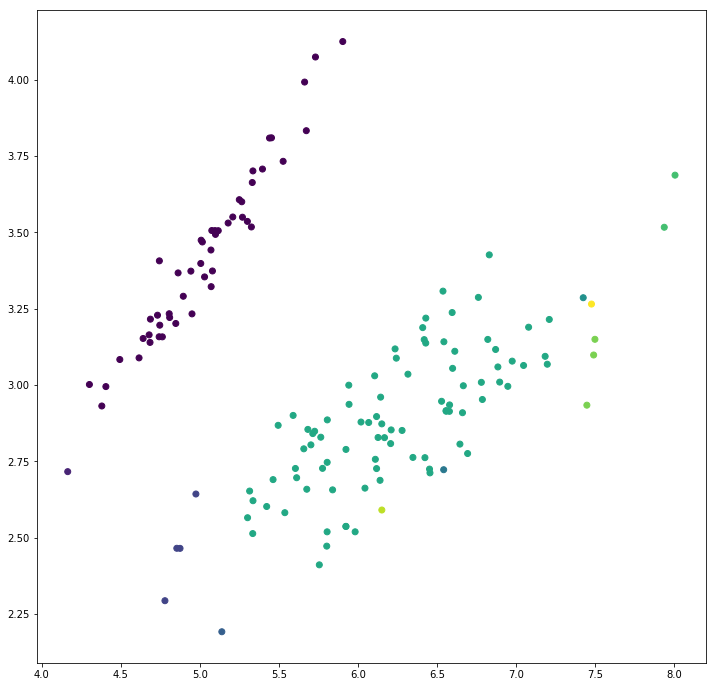

In [109]:
draw(ix,cl._c_all[-3])
#draw(ix, iy)

delta: 0.004, d: 0.004
Sum pos: 55021.878, sum neg: 2.422, Std pos: 0.683, Std neg: 0.000
delta: 0.004, d: 0.001
Sum pos: 53497.364, sum neg: 3.585, Std pos: 0.685, Std neg: 0.000
delta: 0.004, d: 0.000
Sum pos: 51358.085, sum neg: 4.682, Std pos: 0.688, Std neg: 0.000
delta: 0.004, d: 0.001
Sum pos: 49368.385, sum neg: 5.752, Std pos: 0.686, Std neg: 0.000
delta: 0.004, d: 0.000
Sum pos: 45519.133, sum neg: 6.659, Std pos: 0.680, Std neg: 0.000
delta: 0.004, d: 0.000
Sum pos: 38360.192, sum neg: 7.145, Std pos: 0.680, Std neg: 0.000
delta: 0.004, d: 0.000
Sum pos: 33024.587, sum neg: 7.582, Std pos: 0.682, Std neg: 0.000
delta: 0.004, d: 0.000
Sum pos: 27469.235, sum neg: 7.801, Std pos: 0.679, Std neg: 0.000
delta: 0.004, d: 0.000
Sum pos: 22056.392, sum neg: 7.736, Std pos: 0.687, Std neg: 0.000
delta: 0.004, d: 0.000
Sum pos: 17883.733, sum neg: 7.663, Std pos: 0.690, Std neg: 0.000
delta: 0.004, d: 0.000
Sum pos: 13832.473, sum neg: 7.388, Std pos: 0.683, Std neg: 0.000
delta: 0.0

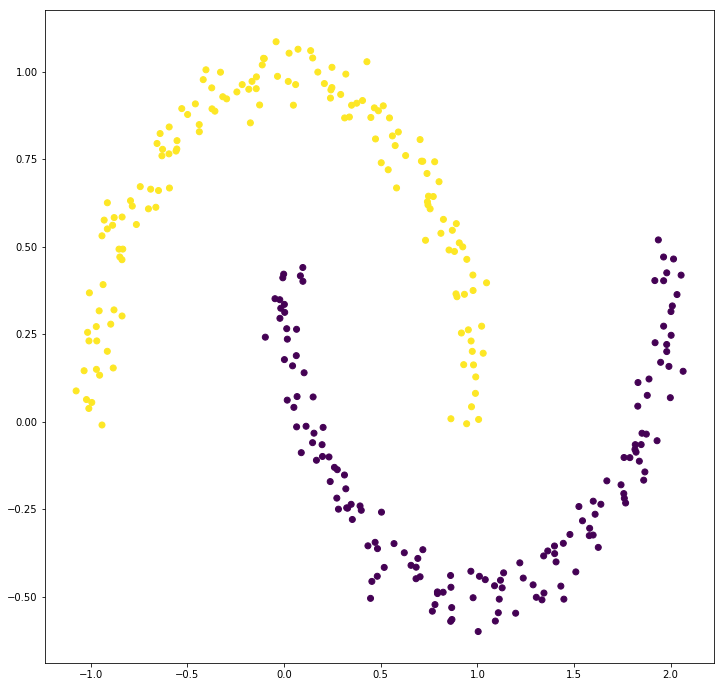

In [110]:
# noisy_moons
from sklearn import cluster, datasets, mixture
mx,my =  datasets.make_moons(n_samples=300, noise=.05)

cl2 = HierarchicalClustering(alpha=1., debug=1)
mmy = cl2.fit(mx)
draw(mx,mmy)

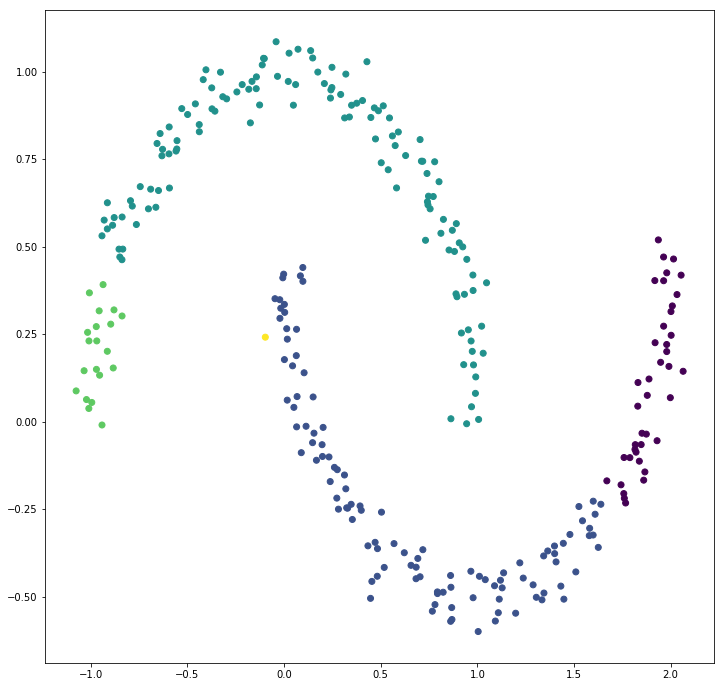

In [111]:
n = -2
#print(cl2._c_all[n])
draw(mx,cl2._c_all[n])

delta: 0.500, d: 0.005
Sum pos: 44094.590, sum neg: 87.000, Std pos: 8.205, Std neg: 0.000
delta: 0.500, d: 0.001
Sum pos: 1188.706, sum neg: 21.000, Std pos: 8.382, Std neg: 0.000
delta: 0.500, d: 0.000
Sum pos: 324.917, sum neg: 14.000, Std pos: 8.782, Std neg: 0.000
delta: 0.500, d: 0.000
Sum pos: 98.302, sum neg: 10.000, Std pos: 8.884, Std neg: 0.000
delta: 0.500, d: 0.000
Sum pos: 19.955, sum neg: 6.000, Std pos: 0.000, Std neg: 0.000


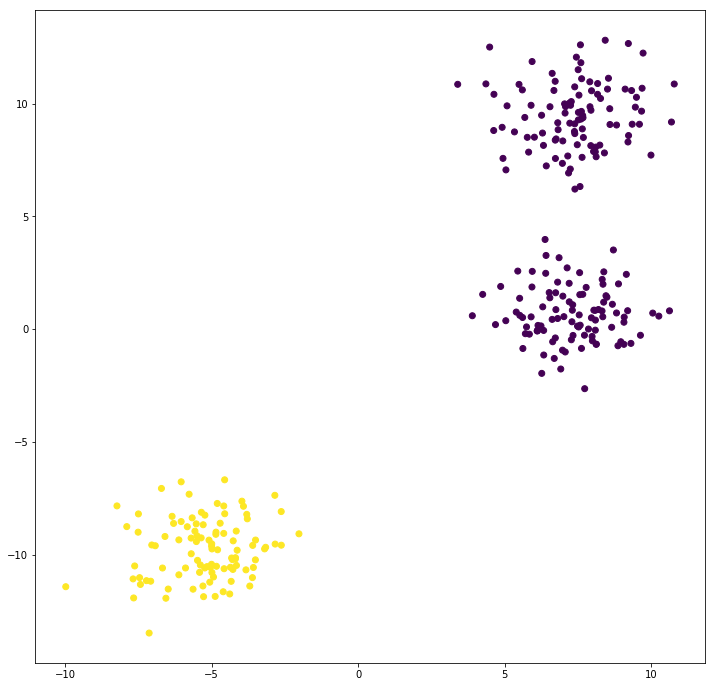

In [112]:
bx,_ =  datasets.make_blobs(n_samples=300, random_state=8, cluster_std=1.3) 

cl3 = HierarchicalClustering(alpha=1., debug=1,max_iteration=100,delta=.5)
by = cl3.fit(bx)
draw(bx,by)

[0. 1. 2. 3. 4. 5. 6.]


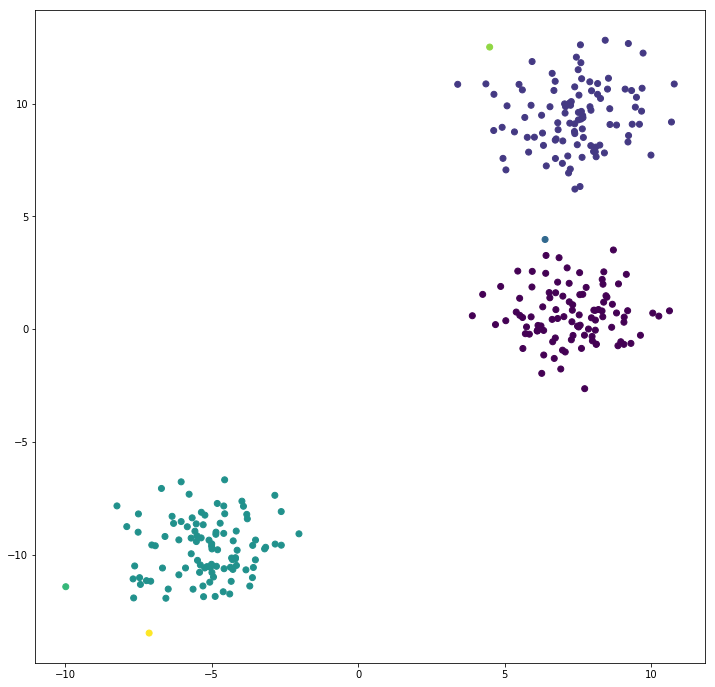

In [113]:
n = -3
#print(cl3._c_all[n])
print(np.unique(cl3._c_all[n]))
draw(bx,cl3._c_all[n])

### fetch_20newsgroups

In [8]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
data_train = fetch_20newsgroups(subset='train', shuffle=True, random_state=42) 
data_test = fetch_20newsgroups(subset='test',  shuffle=True, random_state=42)
print('data loaded')

data loaded


In [4]:
y_train, y_test = data_train.target, data_test.target

In [7]:
print(np.unique(y_train))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [10]:
%%time
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words='english')
X_train = vectorizer.fit_transform(data_train.data)
X_test = vectorizer.transform(data_test.data)

CPU times: user 6.38 s, sys: 16 ms, total: 6.4 s
Wall time: 6.41 s


In [13]:
from sklearn.decomposition import TruncatedSVD

def encode_svd(x, k=100): 
    svd_model = TruncatedSVD(n_components=k, algorithm='randomized', n_iter=100, random_state=42)
    x1 = svd_model.fit_transform(x) 
    return x1 

In [14]:
%%time
X_train_ = encode_svd(X_train)

CPU times: user 3min 6s, sys: 1min 36s, total: 4min 43s
Wall time: 2min 55s


In [15]:
print(X_train_.shape)

(11314, 100)
